# Profiling and Optimising

IPython provides some tools for making it a bit easier to profile and optimise your code.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import seaborn as sns

## `%timeit`

The main IPython tool we are going to use here is `%timeit`,
a magic that automates measuring how long it takes to run a snippet of code.

In [3]:
for N in (100, 500, 1000, 2000):
    print("Size: {0} x {0}".format(N))
    A = np.random.random((N, N))
    %timeit A.dot(A)

Size: 100 x 100
105 µs ± 22.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Size: 500 x 500
5.29 ms ± 257 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Size: 1000 x 1000
35.3 ms ± 988 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Size: 2000 x 2000
290 ms ± 11.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Let's look at what options `%timeit` can take.

In [4]:
%timeit?

Docstring:
Time execution of a Python statement or expression

Usage, in line mode:
  %timeit [-n<N> -r<R> [-t|-c] -q -p<P> -o] statement
or in cell mode:
  %%timeit [-n<N> -r<R> [-t|-c] -q -p<P> -o] setup_code
  code
  code...

Time execution of a Python statement or expression using the timeit
module.  This function can be used both as a line and cell magic:

- In line mode you can time a single-line statement (though multiple
  ones can be chained with using semicolons).

- In cell mode, the statement in the first line is used as setup code
  (executed but not timed) and the body of the cell is timed.  The cell
  body has access to any variables created in the setup code.

Options:
-n<N>: execute the given statement <N> times in a loop. If <N> is not
provided, <N> is determined so as to get sufficient accuracy.

-r<R>: number of repeats <R>, each consisting of <N> loops, and take the
best result.
Default: 7

-t: use time.time to measure the time, which is the default on Unix.
This f

We can save the result in an object with `%timeit -o`,
and specify to only run one group of 100 iterations.

In [5]:
A = np.random.random((100, 100))
tr = %timeit -o -n 1 -r 100 A.dot(A)

The slowest run took 352.44 times longer than the fastest. This could mean that an intermediate result is being cached.
3.08 ms ± 8.72 ms per loop (mean ± std. dev. of 100 runs, 1 loop each)


In [6]:
tr

<TimeitResult : 3.08 ms ± 8.72 ms per loop (mean ± std. dev. of 100 runs, 1 loop each)>

In [7]:
tr.best

0.00015427400012413273

In [8]:
tr.best, tr.worst

(0.00015427400012413273, 0.054372911999962525)

In [9]:
print(len(tr.all_runs))
tr.all_runs[:10]

100


[0.04027890700012904,
 0.0037274010001056013,
 0.0015483250001580018,
 0.00019890199996552838,
 0.00021721000007346447,
 0.0002020409999659023,
 0.00021426399985102762,
 0.0002445300001454598,
 0.00021519300003092212,
 0.0001849559998845507]

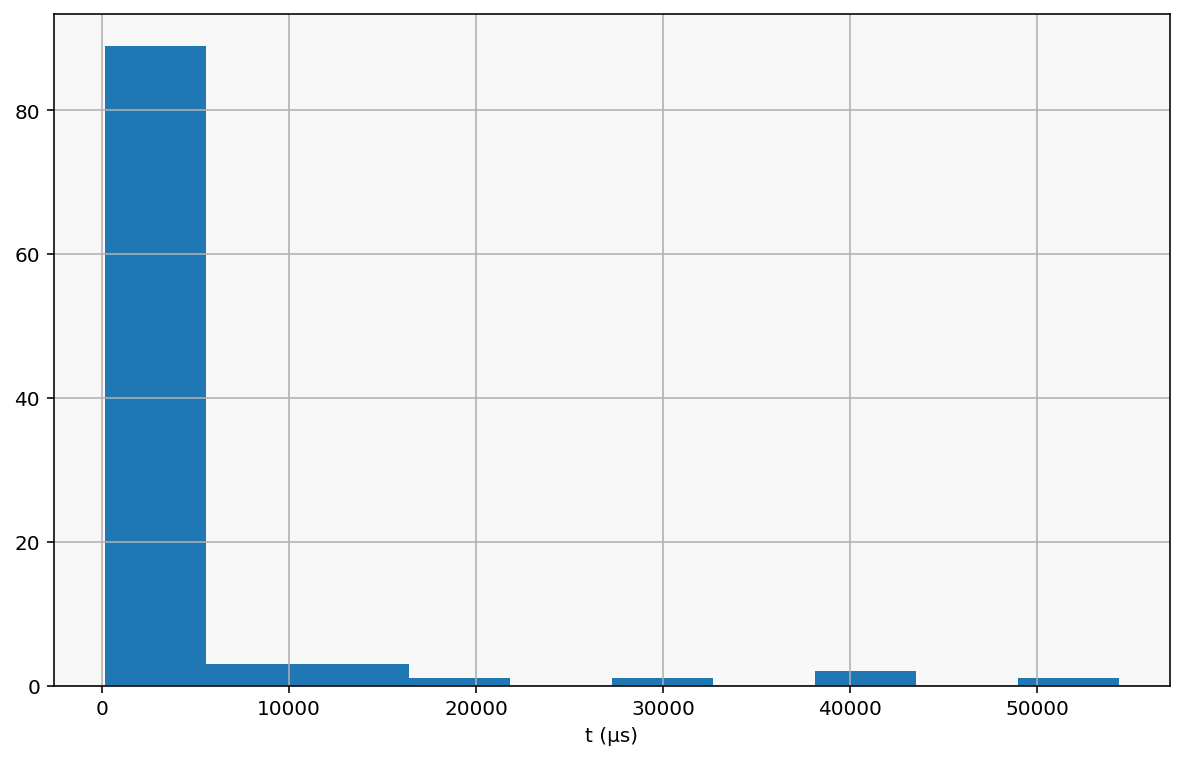

In [10]:
plt.hist(np.array(tr.all_runs) * 1e6)
plt.xlabel("t (µs)");

## Diffusing a wave

Our task is to optimise a 1-D diffusion algorithm,
using numpy and Cython.

Our input signal is a sawtooth wave:

$$
x_\mathrm{sawtooth}(t) = \frac{A}{2}-\frac {A}{\pi}\sum_{k=1}^{\infty}\frac {\sin (2\pi kft)}{k}
$$

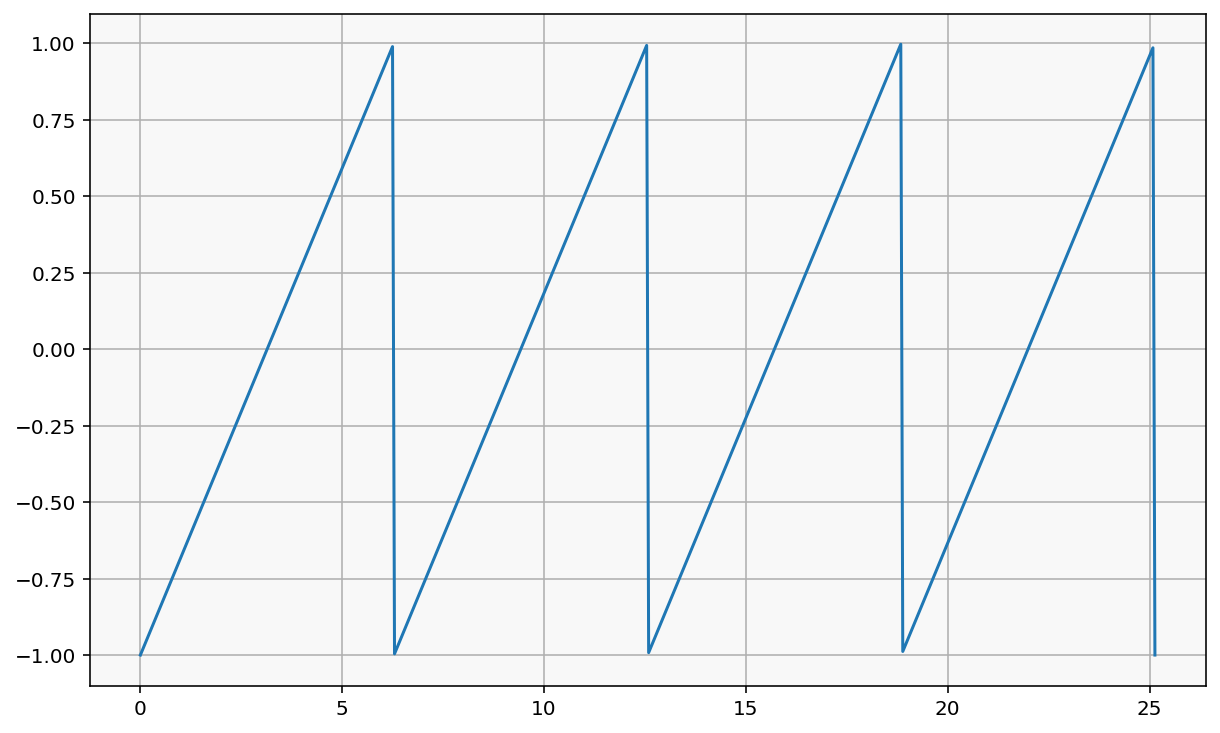

In [11]:
from scipy.signal import sawtooth

T = 8 * np.pi
t = np.linspace(0, T, 512)
x = sawtooth(t)
plt.plot(t, x)

steps = 2048

We are going to diffuse the wave by evolving the heat equation:

$$
\frac{\delta x}{\delta t} = \alpha \frac{\delta^2 x}{\delta^2}{t}
$$

Which we can discretize for our arrays:

\begin{align}
x_{k} =& \frac{1}{4} \left( 
    x_{k-1}[i-1] +
    2 x_{k-1}[i] +
    x_{k-1}[i+1]
    \right) \\
x_{k}[0] =& x_{0}[0] \\
x_{k}[N] =& x_{0}[N] \\
\end{align}

## Pure Python

We'll start with a pure Python implementation,
to use as a reference.

In [12]:
def blur_py(x, steps=1024):
    x = 1 * x # copy
    y = np.empty_like(x)
    y[0] = x[0]
    y[-1] = x[-1]
    for _ in range(steps):
        for i in range(1, len(x)-1):
            y[i] = .25 * ( y[i-1] + 2 * y[i] + y[i+1] )
        x, y = y, x # swap for next step
    return x

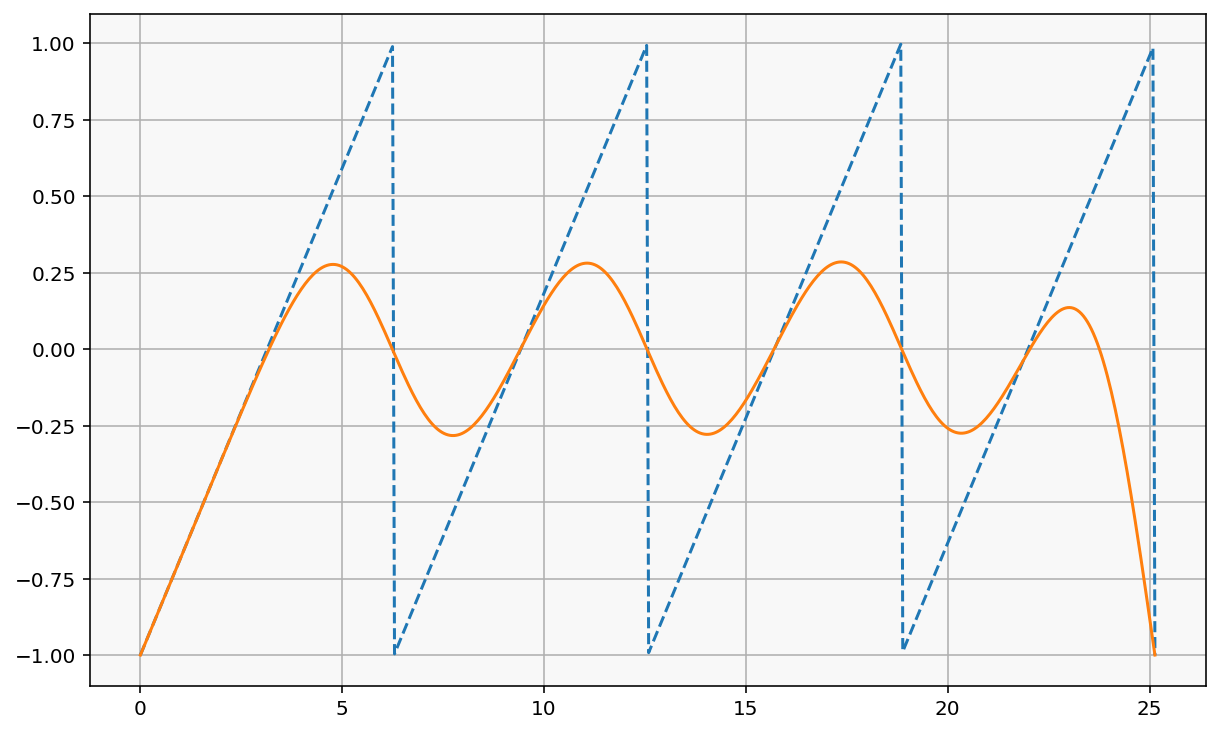

In [13]:
y = blur_py(x, steps)
plt.plot(t, x, '--')
plt.plot(t, y);

Now we can measure how long it takes to run evolve this system:

In [14]:
ref_run = %timeit -o y = blur_py(x, steps)
t_ref = ref_run.best

times = [t_ref]
labels = ['python']

/Users/minrk/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in double_scalars
  
/Users/minrk/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


1.42 s ± 152 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


So it takes about one second.
We can also see how it changes with different times and resolutions.

## Vectorizing with numpy

We can vectorize the inner loop with a single numpy operation:

In [15]:
import numpy as np

def blur_np(x, steps=1024):
    x = 1 * x
    y = np.empty_like(x)
    y[0] = x[0]
    y[-1] = x[-1]
    for _ in range(steps):
        y[1:-1] = .25 * (x[:-2] + 2 * x[1:-1] + x[2:])
        x, y = y, x
    return x

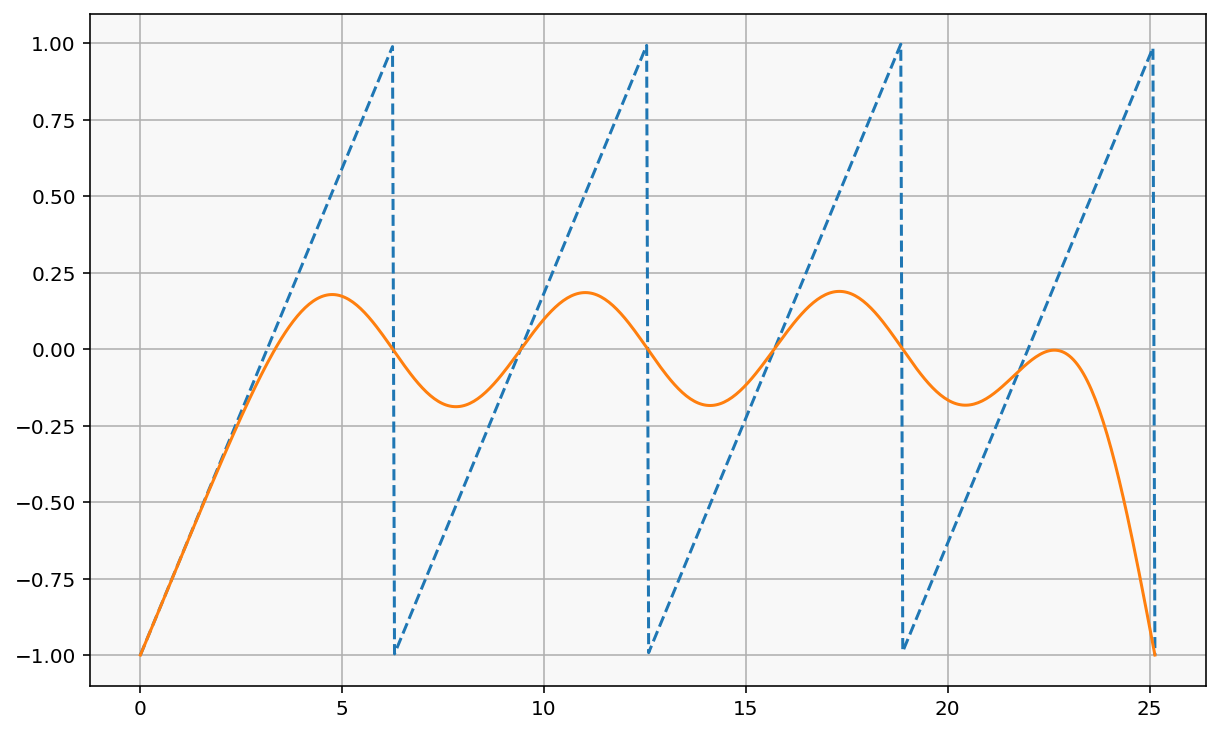

In [16]:
y = blur_np(x, steps)
plt.plot(t, x, '--')
plt.plot(t, y)

In [17]:
np_r = %timeit -o blur_np(x, steps)
t_np = np_r.best

16.3 ms ± 2.72 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [18]:
times.append(t_np)
labels.append('numpy')

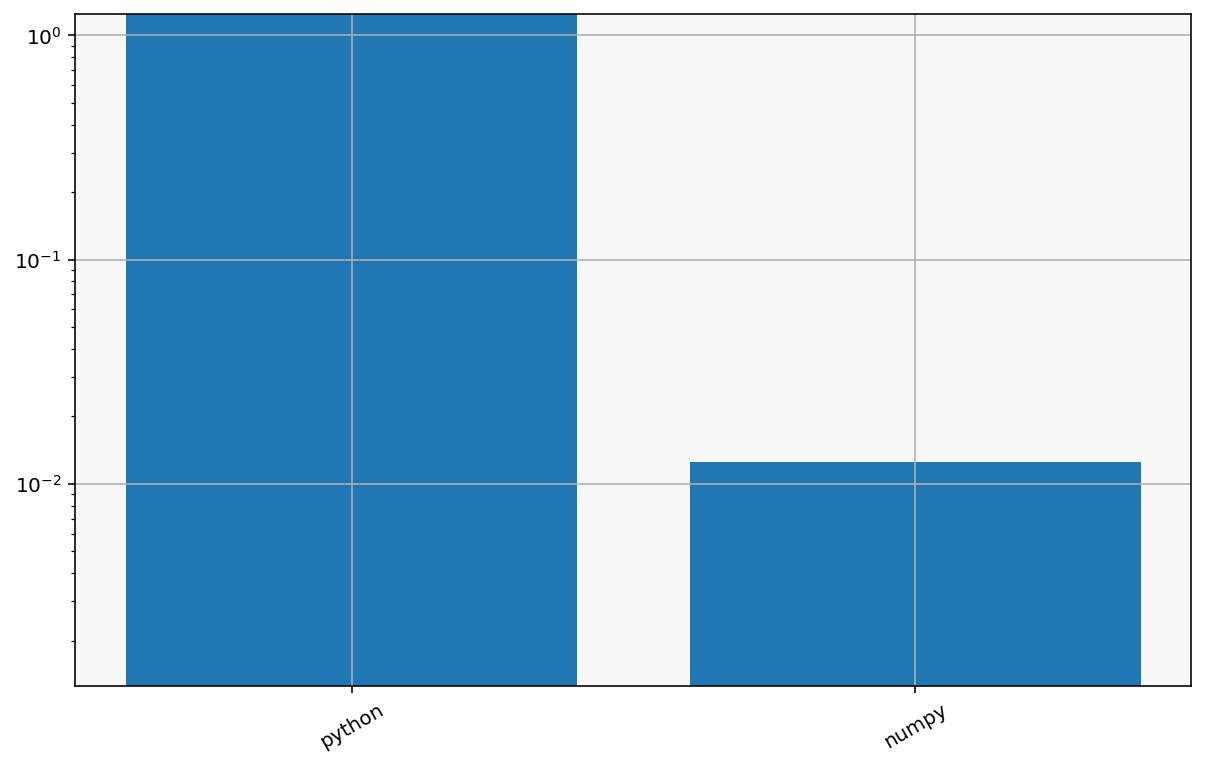

In [19]:
def plot_times():
    ind = np.arange(len(times))
    plt.bar(ind, times, log=True)
    plt.xticks(ind, labels, rotation=30)
    plt.ylim(.1 * min(times), times[0])
plot_times()

So vectorizing the inner loop brings us from ~1 second to 10 milliseconds,
an improvement of ~100x:

In [20]:
t_ref / t_np

99.29645636345155

# Cython

[Cython](http://cython.org/) provides an IPython extension,
which defines a magic we can use to inline bits of Cython code in the notebook:

In [21]:
%load_ext Cython

In [22]:
%%cython

def csum(n):
    cs = 0
    for i in range(n):
        cs += i
    return cs

In [23]:
%timeit csum(5)

524 ns ± 186 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


`%%cython -a` shows you annotations about the generated sourcecode.
The key to writing Cython is to minimize the amount of Python calls in the generated code. In general: yellow = slow.

In [24]:
def psum(n):
    cs = 0
    for i in range(n):
        cs += i
    return cs

In [25]:
%%cython -a

def csum(n):
    cs = 0
    for i in range(n):
        cs += i
    return cs

Uh oh, that looks like a lot of yellow.
We can reduce it by adding some type annotations:

In [26]:
%%cython -a

def csum2(int n):
    cdef int i
    cs = 0
    for i in range(n):
        cs += i
    return cs

Almost there, but I still see yellow on the lines with `cs`:

In [27]:
%%cython -a

cpdef int csum3(int n):
    cdef int i
    cdef int cs = 0
    for i in range(n):
        cs += i
    return cs

Much better!
Now there's only Python when entering the function,
which is about as good as we can do.

In [28]:
N = 1_000_000
print('psum ', end=' ')
%timeit psum (N)
print('csum ', end=' ')
%timeit csum (N)
print('csum2', end=' ')
%timeit csum2(N)
print('csum3', end=' ')
%timeit csum3(N)

psum  75.8 ms ± 7.19 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
csum  54.5 ms ± 10.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
csum2 50.3 ms ± 3.28 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
csum3 104 ns ± 17.7 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


## Blurring with Cython

Now we can apply the same principles to writing a blur
in Cython.

In [29]:
%%cython -a

import numpy as np

def blur_cython(x, steps=1024):
    x = 1 * x # copy
    y = np.empty_like(x)
    y[0] = x[0]
    y[-1] = x[-1]
    for _ in range(steps):
        for i in range(1, len(x)-1):
            y[i] = .25 * ( x[i-1] + 2 * x[i] + x[i+1] )
        x, y = y, x # swap for next step
    return x

In [30]:
c1 = %timeit -o y = blur_cython(x, steps)
t_c1 = c1.best
times.append(t_c1)
labels.append("cython (no hints)")

1.26 s ± 181 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


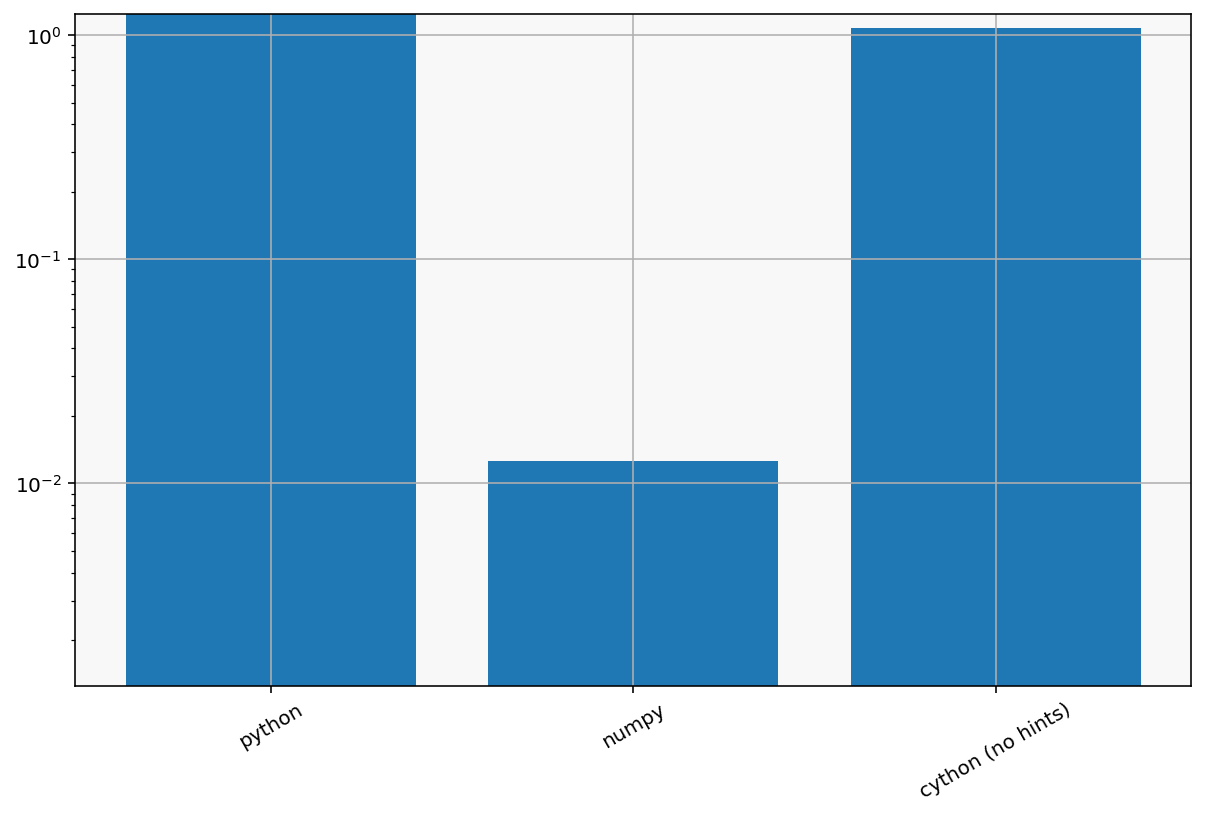

In [31]:
plot_times()

Without annotations, we don't get much improvement over the pure Python version.
We can note the types of the input arguments, to get some improvements:

In [32]:
%%cython -a

import numpy as np
cimport numpy as np

def blur_cython2(x, int steps=1024):
    x = 1 * x # copy
    y = np.empty_like(x)
    y[0] = x[0]
    y[-1] = x[-1]
    cdef int i, N = len(x)
    for _ in range(steps):
        for i in range(1, N-1):
            y[i] = .25 * ( x[i-1] + 2 * x[i] + x[i+1] )
        x, y = y, x # swap for next step
    return x

1 s ± 133 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


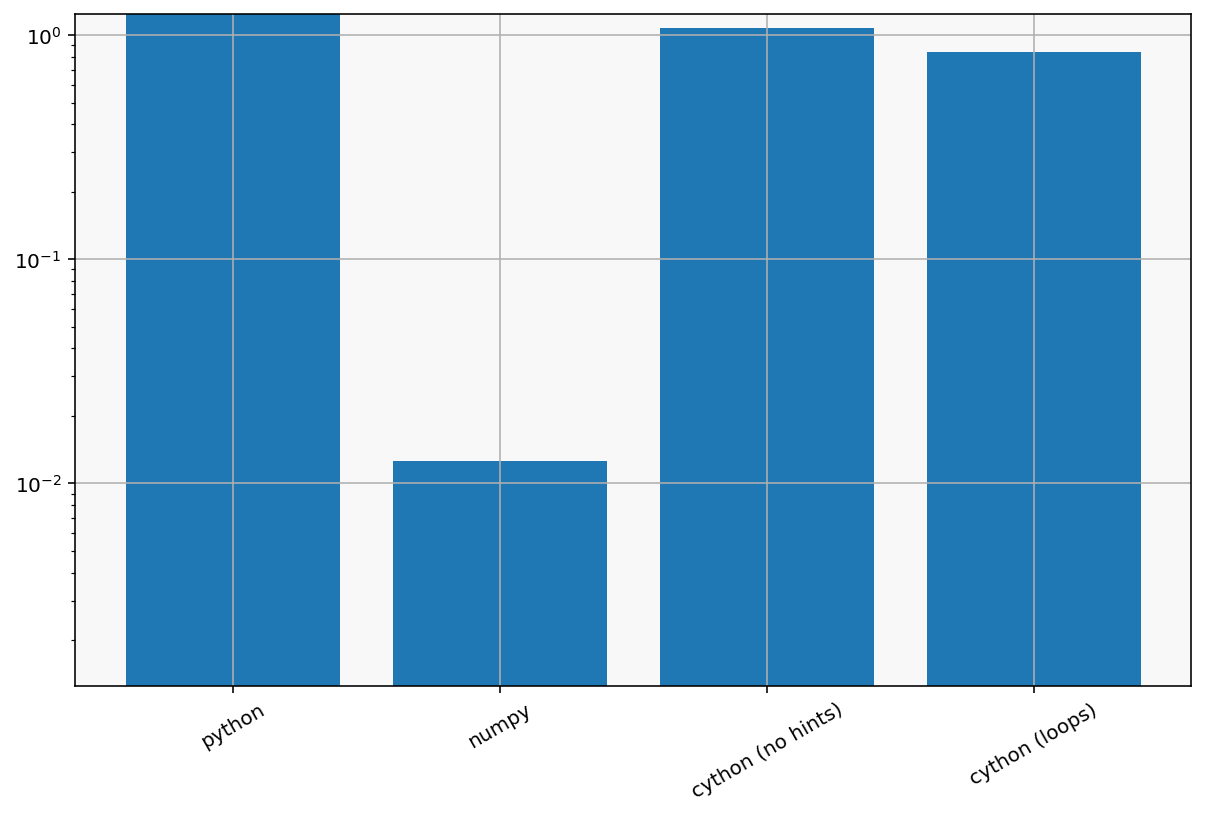

In [33]:
c2 = %timeit -o blur_cython2(x, steps)
t_c2 = c2.best
times.append(t_c2)
labels.append("cython (loops)")
plot_times()

Just by making sure the iteration variables are defined as integers, we can save about 25% of the time.

The biggest key to optimizing with Cython is getting that yellow out of your loops.
The more deeply nested a bit of code is within a loop,
the more often it is called, and the more value you can get out of making it fast.
In Cython, fast means avoiding Python (getting rid of yellow).
To get rid of Python calls, we need to tell Python about the numpy arrays `x` and `y`:


In [34]:
%%cython -a

import numpy as np
cimport numpy as np

def blur_cython_typed(np.ndarray[double, ndim=1] x_, int steps=1024):
    cdef size_t i, N = x_.shape[0]
    cdef np.ndarray[double, ndim=1] x
    cdef np.ndarray[double, ndim=1] y
    x = 1 * x_ # copy
    y = np.empty_like(x_)
    y[0] = x[0]
    y[-1] = x[-1]
    for _ in range(steps):
        for i in range(1, N-1):
            y[i] = .25 * ( y[i-1] + 2 * y[i] + y[i+1] )
        x, y = y, x # swap for next step
    return x

10.6 ms ± 1.83 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


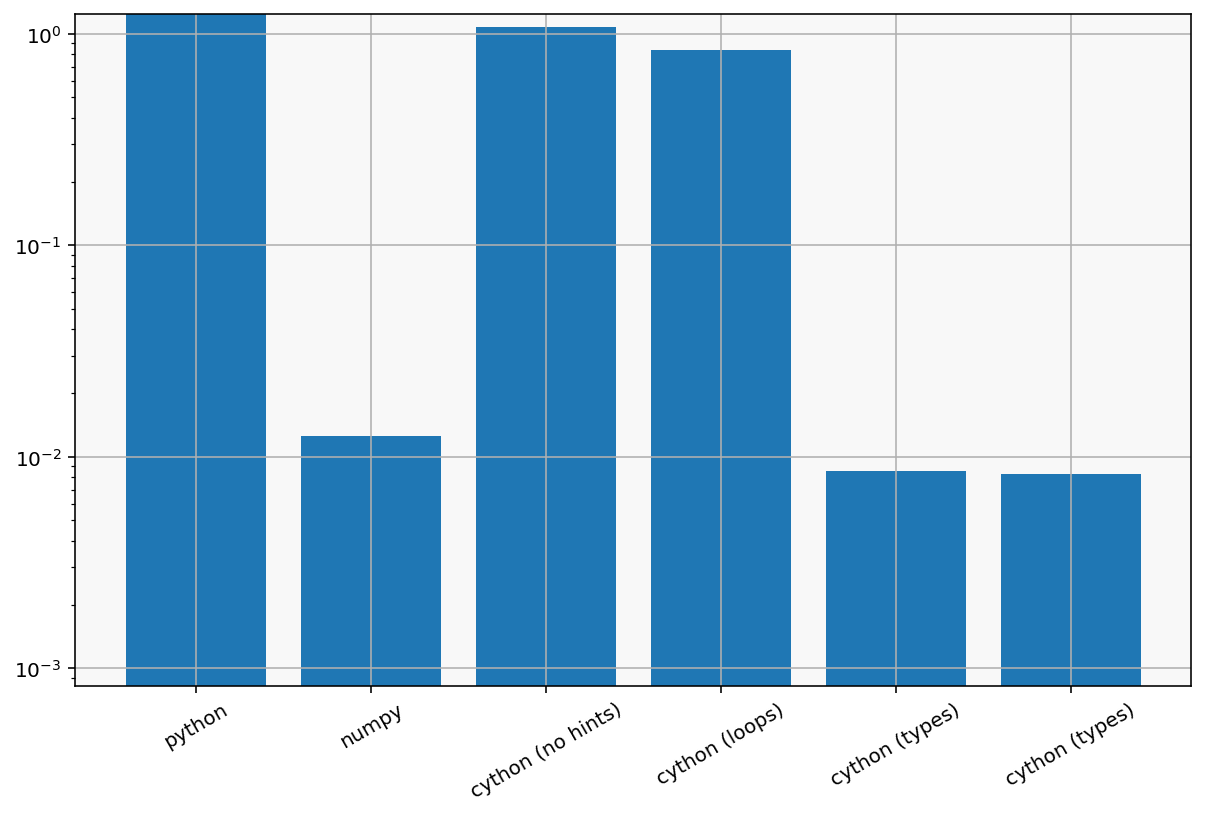

In [36]:
ct = %timeit -o y = blur_cython_typed(x, steps)
t_ct = ct.best

times.append(t_ct)
labels.append("cython (types)")
plot_times()

We can further optimize with Cython macros,
which disable bounds checking and negative indexing,
and avoiding the Python variable swaping by using indices into a single array:

In [37]:
x[len(x)]

IndexError: index 512 is out of bounds for axis 0 with size 512

In [38]:
%%cython -a
#cython: boundscheck=False
#cython: wraparound=False

import numpy as np
cimport numpy as np

def blur_cython_optimized(np.ndarray[double, ndim=1] x, int steps=1024):
    cdef size_t N = x.shape[0]
    cdef np.ndarray[double, ndim=2] y
    y = np.empty((2, N), dtype=np.float64)
    y[0,:] = x
    y[1,0] = x[0]
    y[1,N-1] = x[N-1]
    
    cdef size_t _, i, j=0, k=1
    for _ in range(steps):
        j = _ % 2
        k = 1 - j
        for i in range(1, N-1):
            y[k,i] = .25 * ( y[j,i-1] + 2 * y[j,i] + y[j,i+1] )
    return y[k]

Note how there is now zero yellow called in any of the loops,
only in the initial copy of the input array.

1.32 ms ± 321 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


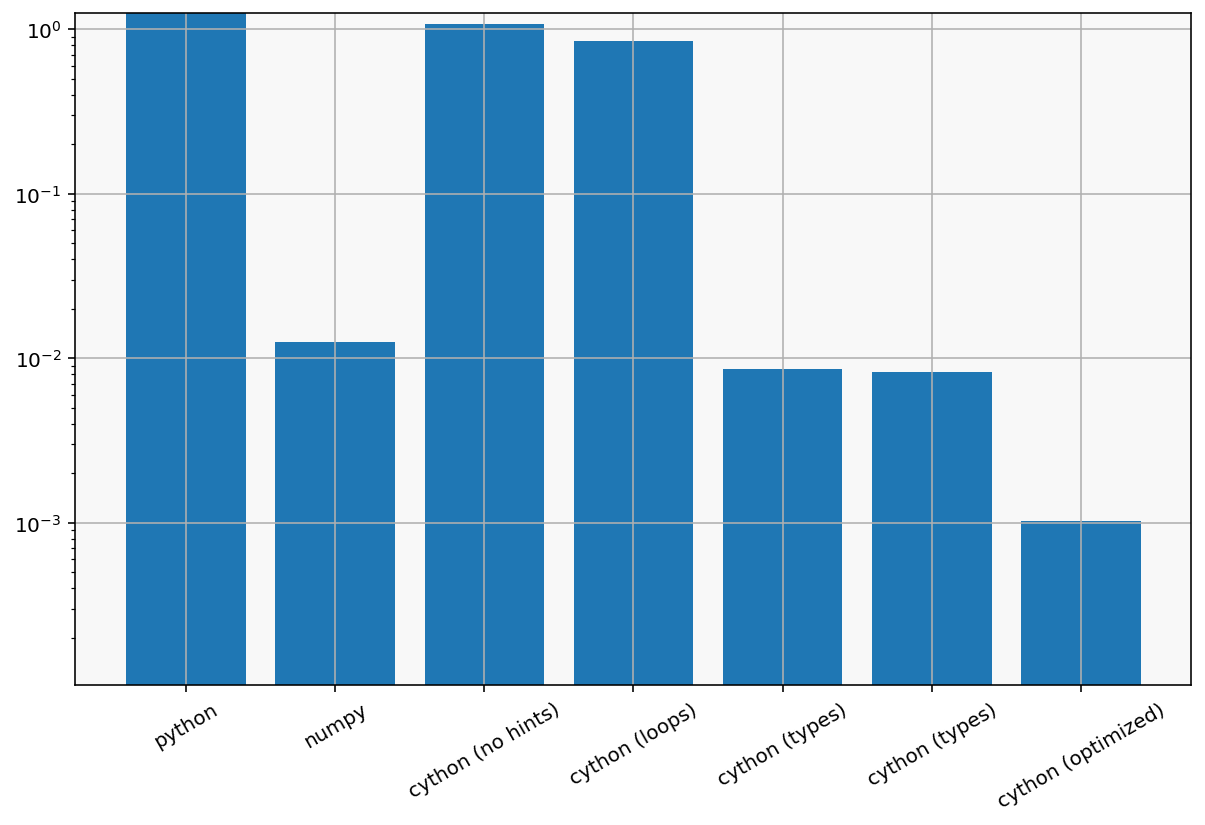

In [39]:
copt = %timeit -o y = blur_cython_optimized(x, steps)
t_copt = copt.best
times.append(t_copt)
labels.append("cython (optimized)")
plot_times()

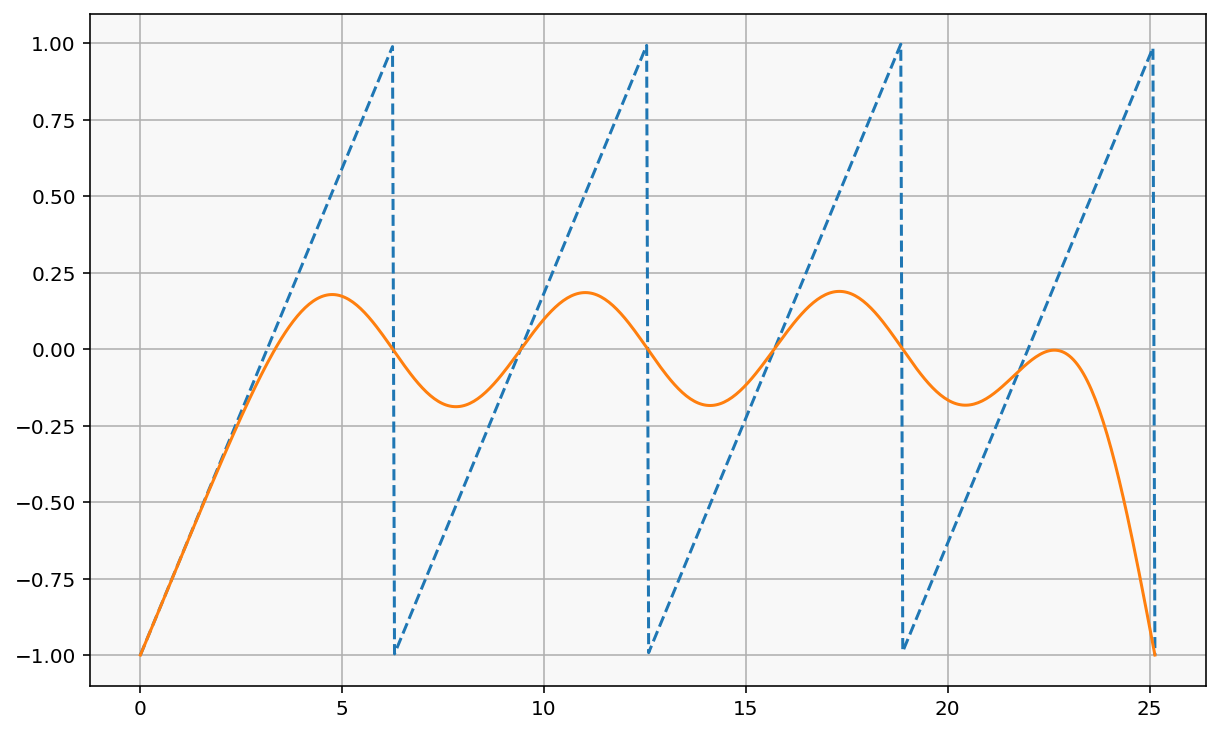

In [40]:
y = blur_cython_optimized(x, steps)
plt.plot(t, x, '--')
plt.plot(t, y)

## numba

[numba](http://numba.pydata.org/) is a library that attempts to automatically do type-based optimizations like we did with Cython.
To use numba, you decorate functions with `@autojit`.

In [41]:
import numba

@numba.jit
def blur_numba(x, steps=1024):
    """identical to blur_py, other than the decorator"""
    x = 1 * x # copy
    y = np.empty_like(x)
    y[0] = x[0]
    y[-1] = x[-1]
    for _ in range(steps):
        for i in range(1, len(x)-1):
            y[i] = .25 * ( y[i-1] + 2 * y[i] + y[i+1] )
        x, y = y, x # swap for next step
    return x

y = blur_numba(x, steps)

4.98 ms ± 1.38 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


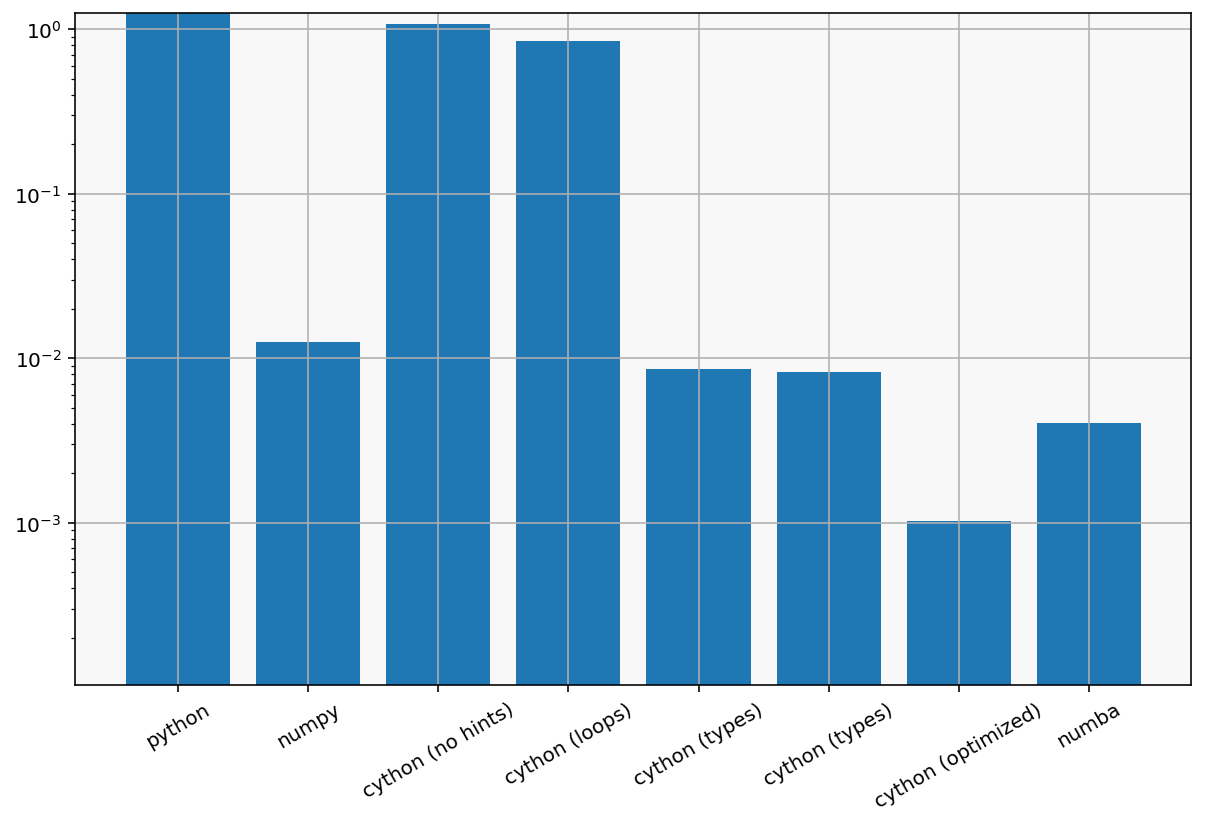

In [42]:
nb = %timeit -o blur_numba(x, steps)
t_nb = nb.best
times.append(t_nb)
labels.append("numba")
plot_times()

In [43]:
blur_numba.inspect_types()

blur_numba (array(float64, 1d, C), int64)
--------------------------------------------------------------------------------
# File: <ipython-input-41-8e1a43dd8f73>
# --- LINE 3 --- 

@numba.jit

# --- LINE 4 --- 

def blur_numba(x, steps=1024):

    # --- LINE 5 --- 

    """identical to blur_py, other than the decorator"""

    # --- LINE 6 --- 
    # label 0
    #   x = arg(0, name=x)  :: array(float64, 1d, C)
    #   steps = arg(1, name=steps)  :: int64
    #   $const2.0 = const(int, 1)  :: Literal[int](1)
    #   del $const2.0
    #   $6binary_multiply.2 = arrayexpr(expr=(<built-in function mul>, [const(int, 1), Var(x, <ipython-input-41-8e1a43dd8f73>:6)]), ty=array(float64, 1d, C))  :: array(float64, 1d, C)
    #   del x
    #   x.1 = $6binary_multiply.2  :: array(float64, 1d, C)
    #   del $6binary_multiply.2

    x = 1 * x # copy

    # --- LINE 7 --- 
    #   $10load_global.3 = global(np: <module 'numpy' from '/Users/minrk/conda/lib/python3.7/site-packages/numpy/__init__.py'>)  

What's impressive about numba in this case
is that it is able to beat all but the most optimized of our implementations without any help.
Like Cython, numba can do an even better job when you provide it with more information about how a function will be called.

## Profiling

In [44]:
import sys

In [45]:
%prun list(os.walk(sys.prefix))

         2034827 function calls (1706149 primitive calls) in 12.977 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    41675    5.852    0.000    5.852    0.000 {built-in method posix.lstat}
   429803    2.689    0.000    2.689    0.000 {built-in method builtins.next}
    41659    1.456    0.000    1.456    0.000 {built-in method posix.scandir}
   388144    1.224    0.000    1.224    0.000 {method 'is_dir' of 'posix.DirEntry' objects}
370338/41660    1.204    0.000   12.932    0.000 os.py:278(walk)
    41675    0.198    0.000    0.312    0.000 posixpath.py:75(join)
    41675    0.100    0.000    5.968    0.000 posixpath.py:168(islink)
   388144    0.062    0.000    0.062    0.000 {method 'append' of 'list' objects}
        1    0.044    0.044   12.976   12.976 <string>:1(<module>)
    41675    0.034    0.000    0.034    0.000 {method 'startswith' of 'str' objects}
    83334    0.030    0.000    0.030    0.000 {built-in met

In [46]:
%load_ext snakeviz

In [47]:
%snakeviz -t blur_py(x, steps)

/Users/minrk/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in double_scalars
  


 
*** Profile stats marshalled to file '/var/folders/qr/3vxfnp1x2t1fw55dr288mphc0000gn/T/tmpor5bpe_l'. 
Opening SnakeViz in a new tab...


In [48]:
import hashlib

In [49]:
%%snakeviz -t
for dirpath, dirnames, filenames in os.walk('/usr/local'):
    for filename in filenames:
        if filename.endswith('.txt'):
            full_path = os.path.join(dirpath, filename)
            with open(full_path, 'rb') as f:
                hashlib.md5(f.read())

 
*** Profile stats marshalled to file '/var/folders/qr/3vxfnp1x2t1fw55dr288mphc0000gn/T/tmpu6n7g_qz'. 
Opening SnakeViz in a new tab...


In [50]:
%load_ext line_profiler

In [51]:
%lprun -f blur_py blur_py(x, steps)

Timer unit: 1e-06 s

Total time: 3.06017 s
File: <ipython-input-12-2800351f2b6f>
Function: blur_py at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def blur_py(x, steps=1024):
     2         1        226.0    226.0      0.0      x = 1 * x # copy
     3         1         72.0     72.0      0.0      y = np.empty_like(x)
     4         1          5.0      5.0      0.0      y[0] = x[0]
     5         1          1.0      1.0      0.0      y[-1] = x[-1]
     6      2049       1255.0      0.6      0.0      for _ in range(steps):
     7   1046528     597212.0      0.6     19.5          for i in range(1, len(x)-1):
     8   1044480    2459758.0      2.4     80.4              y[i] = .25 * ( y[i-1] + 2 * y[i] + y[i+1] )
     9      2048       1638.0      0.8      0.1          x, y = y, x # swap for next step
    10         1          1.0      1.0      0.0      return x

In [52]:
%lprun -f blur_np blur_np(x, steps)

Timer unit: 1e-06 s

Total time: 0.054523 s
File: <ipython-input-15-43edd39cb233>
Function: blur_np at line 3

Line #      Hits         Time  Per Hit   % Time  Line Contents
     3                                           def blur_np(x, steps=1024):
     4         1        248.0    248.0      0.5      x = 1 * x
     5         1         15.0     15.0      0.0      y = np.empty_like(x)
     6         1          6.0      6.0      0.0      y[0] = x[0]
     7         1          1.0      1.0      0.0      y[-1] = x[-1]
     8      2049       1753.0      0.9      3.2      for _ in range(steps):
     9      2048      49106.0     24.0     90.1          y[1:-1] = .25 * (x[:-2] + 2 * x[1:-1] + x[2:])
    10      2048       3393.0      1.7      6.2          x, y = y, x
    11         1          1.0      1.0      0.0      return x

In [53]:
%lprun -f blur_numba blur_numba(x, steps)

Timer unit: 1e-06 s

Total time: 0 s
File: <ipython-input-41-8e1a43dd8f73>
Function: blur_numba at line 3

Line #      Hits         Time  Per Hit   % Time  Line Contents
     3                                           @numba.jit
     4                                           def blur_numba(x, steps=1024):
     5                                               """identical to blur_py, other than the decorator"""
     6                                               x = 1 * x # copy
     7                                               y = np.empty_like(x)
     8                                               y[0] = x[0]
     9                                               y[-1] = x[-1]
    10                                               for _ in range(steps):
    11                                                   for i in range(1, len(x)-1):
    12                                                       y[i] = .25 * ( y[i-1] + 2 * y[i] + y[i+1] )
    13                                   

In [54]:
%lprun -f blur_cython blur_cython(x, steps)

/Users/minrk/conda/lib/python3.7/site-packages/line_profiler/line_profiler.py:328: UserWarning: Could not extract a code object for the object <built-in function blur_cython>
  profile = LineProfiler(*funcs)


Timer unit: 1e-06 s

In [55]:
%%cython --compile-args=-DCYTHON_TRACE=1

# cython: binding=True
# cython: linetrace=True

import numpy as np

def blur_cython_traced(x, steps=1024):
    x = 1 * x # copy
    y = np.empty_like(x)
    y[0] = x[0]
    y[-1] = x[-1]
    for _ in range(steps):
        for i in range(1, len(x)-1):
            y[i] = .25 * ( x[i-1] + 2 * x[i] + x[i+1] )
        x, y = y, x # swap for next step
    return x

In [56]:
%lprun -f blur_cython_traced blur_cython_traced(x, steps)

Timer unit: 1e-06 s

Total time: 2.38345 s
File: /Users/minrk/.ipython/cython/_cython_magic_90dacae52b9998194d331ffbb53461df.pyx
Function: blur_cython_traced at line 7

Line #      Hits         Time  Per Hit   % Time  Line Contents
     7                                           def blur_cython_traced(x, steps=1024):
     8         1         27.0     27.0      0.0      x = 1 * x # copy
     9         1         11.0     11.0      0.0      y = np.empty_like(x)
    10         1          2.0      2.0      0.0      y[0] = x[0]
    11         1          1.0      1.0      0.0      y[-1] = x[-1]
    12      2049       1407.0      0.7      0.1      for _ in range(steps):
    13   1046528     413997.0      0.4     17.4          for i in range(1, len(x)-1):
    14   1044480    1967403.0      1.9     82.5              y[i] = .25 * ( x[i-1] + 2 * x[i] + x[i+1] )
    15      2048        602.0      0.3      0.0          x, y = y, x # swap for next step
    16         1          3.0      3.0      0.0

In [57]:
%snakeviz -t np.dot(x, x)

 
*** Profile stats marshalled to file '/var/folders/qr/3vxfnp1x2t1fw55dr288mphc0000gn/T/tmpw6ow198b'. 
Opening SnakeViz in a new tab...
